Initial graph as drawn below is derived from chatgpt: https://chatgpt.com/share/17f530f2-8dc4-40ed-bf4c-3dba1106f403

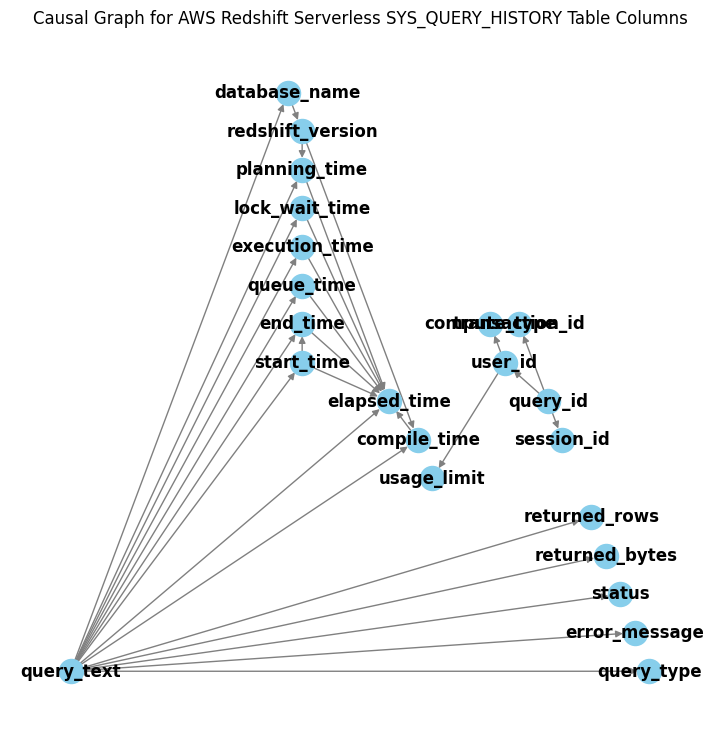

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Creating a directed graph
G = nx.DiGraph()

# Adding nodes (columns)
orig_nodes = ['user_id', 'query_id', 'query_label', 'transaction_id', 'session_id',
           'database_name', 'query_type', 'status', 'result_cache_hit',
           'start_time', 'end_time', 'elapsed_time', 'queue_time',
           'execution_time', 'error_message', 'returned_rows', 'returned_bytes',
           'query_text', 'redshift_version', 'usage_limit', 'compute_type',
           'compile_time', 'planning_time', 'lock_wait_time']

# Adding edges (causal relationships) based on descriptions
orig_edges = [
    ('query_text', 'query_type'),  # query_text influences query_type
    ('query_text', 'database_name'),  # query_text influences database_name
    ('query_text', 'start_time'),  # query_text influences start_time
    ('query_text', 'end_time'),  # query_text influences end_time
    ('query_text', 'elapsed_time'),  # query_text influences elapsed_time
    ('query_text', 'queue_time'),  # query_text influences queue_time
    ('query_text', 'execution_time'),  # query_text influences execution_time
    ('query_text', 'returned_rows'),  # query_text influences returned_rows
    ('query_text', 'returned_bytes'),  # query_text influences returned_bytes
    ('query_text', 'compile_time'),  # query_text influences compile_time
    ('query_text', 'planning_time'),  # query_text influences planning_time
    ('query_text', 'lock_wait_time'),  # query_text influences lock_wait_time
    ('query_text', 'status'),  # query_text influences status
    ('query_text', 'error_message'),  # query_text influences error_message
    ('query_id', 'transaction_id'),  # query_id influences transaction_id
    ('query_id', 'session_id'),  # query_id influences session_id
    ('query_id', 'user_id'),  # query_id influences user_id
    ('start_time', 'end_time'),  # start_time influences end_time
    ('start_time', 'elapsed_time'),  # start_time influences elapsed_time
    ('end_time', 'elapsed_time'),  # end_time influences elapsed_time
    ('execution_time', 'elapsed_time'),  # execution_time influences elapsed_time
    ('compile_time', 'elapsed_time'),  # compile_time influences elapsed_time
    ('planning_time', 'elapsed_time'),  # planning_time influences elapsed_time
    ('queue_time', 'elapsed_time'),  # queue_time influences elapsed_time
    ('lock_wait_time', 'elapsed_time'),  # lock_wait_time influences elapsed_time
    ('user_id', 'usage_limit'),  # user_id influences usage_limit
    ('user_id', 'compute_type'),  # user_id influences compute_type
    ('database_name', 'redshift_version'),  # database_name influences redshift_version
    ('redshift_version', 'compile_time'),  # redshift_version influences compile_time
    ('redshift_version', 'planning_time'),  # redshift_version influences planning_time
]

# Adding edges to the graph
G.add_edges_from(orig_edges)

# Drawing the graph optimizing layout for better visualization
plt.figure(figsize=(7, 7))
pos = nx.planar_layout(G)
nx.draw(G,  pos=pos, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
plt.title("Causal Graph for AWS Redshift Serverless SYS_QUERY_HISTORY Table Columns")
plt.show()


In [1]:
# Dump the edges into the file format that SSumM expects.
import networkx as nx
import pickle

with open('/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual.pkl', 'rb') as f:
    G = pickle.load(f)

# Map each node to an integer and dump the mapping
node_to_int = {node: i for i, node in enumerate(G.nodes())}

with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_node_mapping.csv', 'w') as f:
    for node, i in node_to_int.items():
        f.write(f'{node},{i}\n')

# Dump the edges

with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_input.tsv', 'w') as f:
    for edge in G.edges():
        f.write(f'{node_to_int[edge[0]]}\t{node_to_int[edge[1]]}\n')

Summarized the graph using SSumM with parameters 0.5 and 1

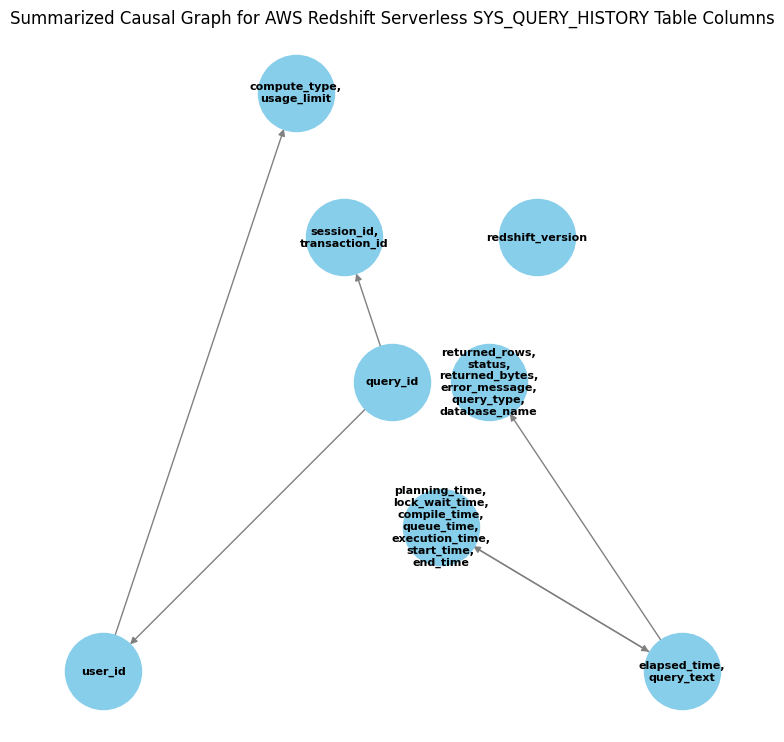

In [ ]:
# Read the summarized graph from the format that SSumM outputs.

# Read the node encoding
int_to_node = {}
with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_node_mapping.csv', 'r') as f:
    for line in f:
        node, i = line.strip().split(',')
        int_to_node[int(i)] = node

# Read the nodes and edges
summ_nodes = dict()
summ_edges = []
reading_nodes = False

with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_output.txt', 'r') as f:
    for line in f:
        if line.startswith('<') and not reading_nodes:
            reading_nodes = True
            continue
        elif line.startswith('<') and reading_nodes:
            reading_nodes = False
            continue
        if reading_nodes:
            l = list(map(int, line.strip().split('\t')))
            for i in range(1, len(l)):
                l[i] = int_to_node[l[i]]
            summ_nodes[l[0]] = {'name': ',\n'.join(l[1:]), 'members': l[1:]}
        else:
            l = list(map(int, line.strip().split('\t')))
            super_source = l[0]
            super_target = l[1]

            for src in summ_nodes[super_source]['members']:
                for tgt in summ_nodes[super_target]['members']:
                    if (src, tgt) in orig_edges:
                        summ_edges.append((summ_nodes[super_source]['name'], summ_nodes[super_target]['name']))
                    elif (tgt, src) in orig_edges:
                        summ_edges.append((summ_nodes[super_target]['name'], summ_nodes[super_source]['name']))



# Create a new graph with the summarized nodes and edges
G_summarized = nx.DiGraph()
summ_node_names = [node['name'] for node in summ_nodes.values()]
G_summarized.add_nodes_from(summ_node_names)
G_summarized.add_edges_from(summ_edges)
plt.figure(figsize=(7, 7))
nx.draw_planar(G_summarized, with_labels=True, node_size=3000, node_color='skyblue', font_size=8, font_weight='bold', edge_color='gray')
plt.title("Summarized Causal Graph for AWS Redshift Serverless SYS_QUERY_HISTORY Table Columns")
plt.show()
